# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.configuration_utils import random_cmap, CONFIG_FILE_HEADER
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import segment_cellpose
from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype_process.extract_phenotype_cp_multichannel import extract_phenotype_cp_multichannel

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# parameters for feature extraction
FOCI_CHANNEL = 2
CHANNEL_NAMES = ["DAPI", "COXIV", "CENPA", "WGA"]

Loading test image...
Applying illumination correction...
Example corrected image:


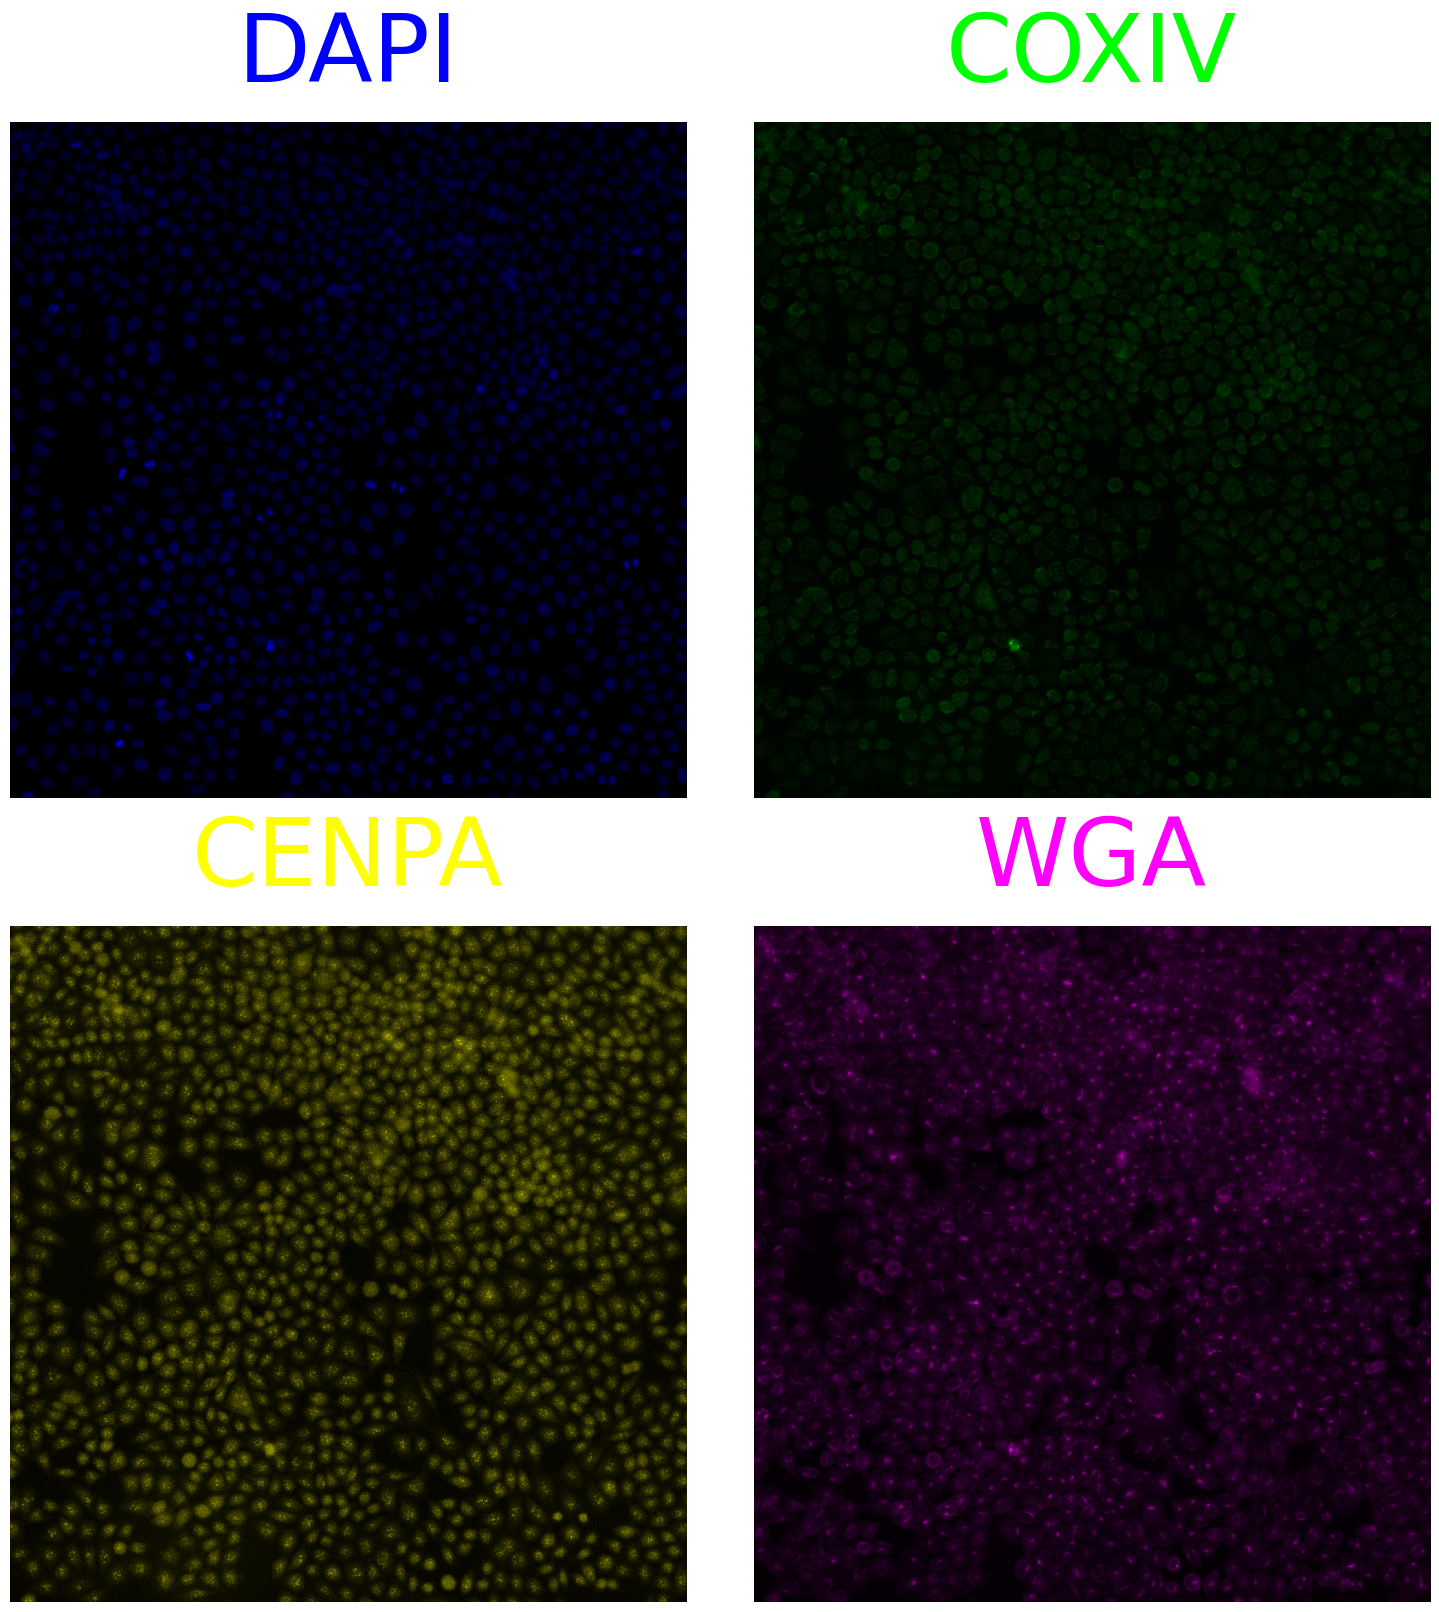

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names=CHANNEL_NAMES[0]
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names=CHANNEL_NAMES[1]
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names=CHANNEL_NAMES[2]
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names=CHANNEL_NAMES[3]
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Define parameters for CellPose segmentation
CYTO_CHANNEL = "COXIV"
NUCLEI_DIAMETER = 47.1
CELL_DIAMETER = 55.3
CYTO_MODEL = "cyto3"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

Segmenting cells...


/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

removing edges


found 1170 nuclei before reconciling
found 1137 cells before reconciling


reconciling masks with method how=consensus


found 1108 nuclei/cells after reconciling


Number of nuclei segmented: 1108
Number of cells segmented: 1108
Example microplots for DAPI channel and nuclei segmentation:


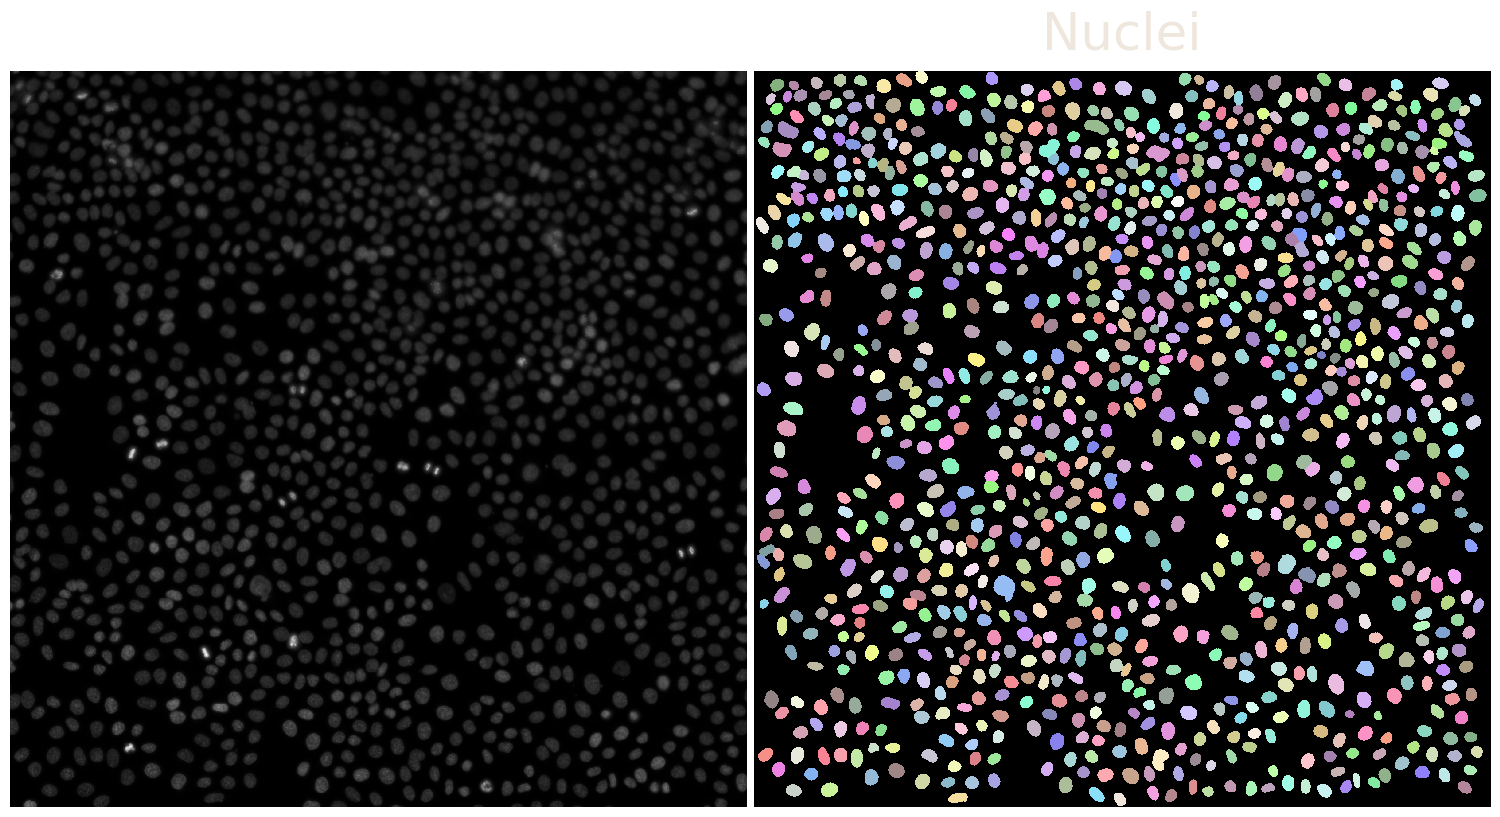

Example microplots for merged channels and cells segmentation:


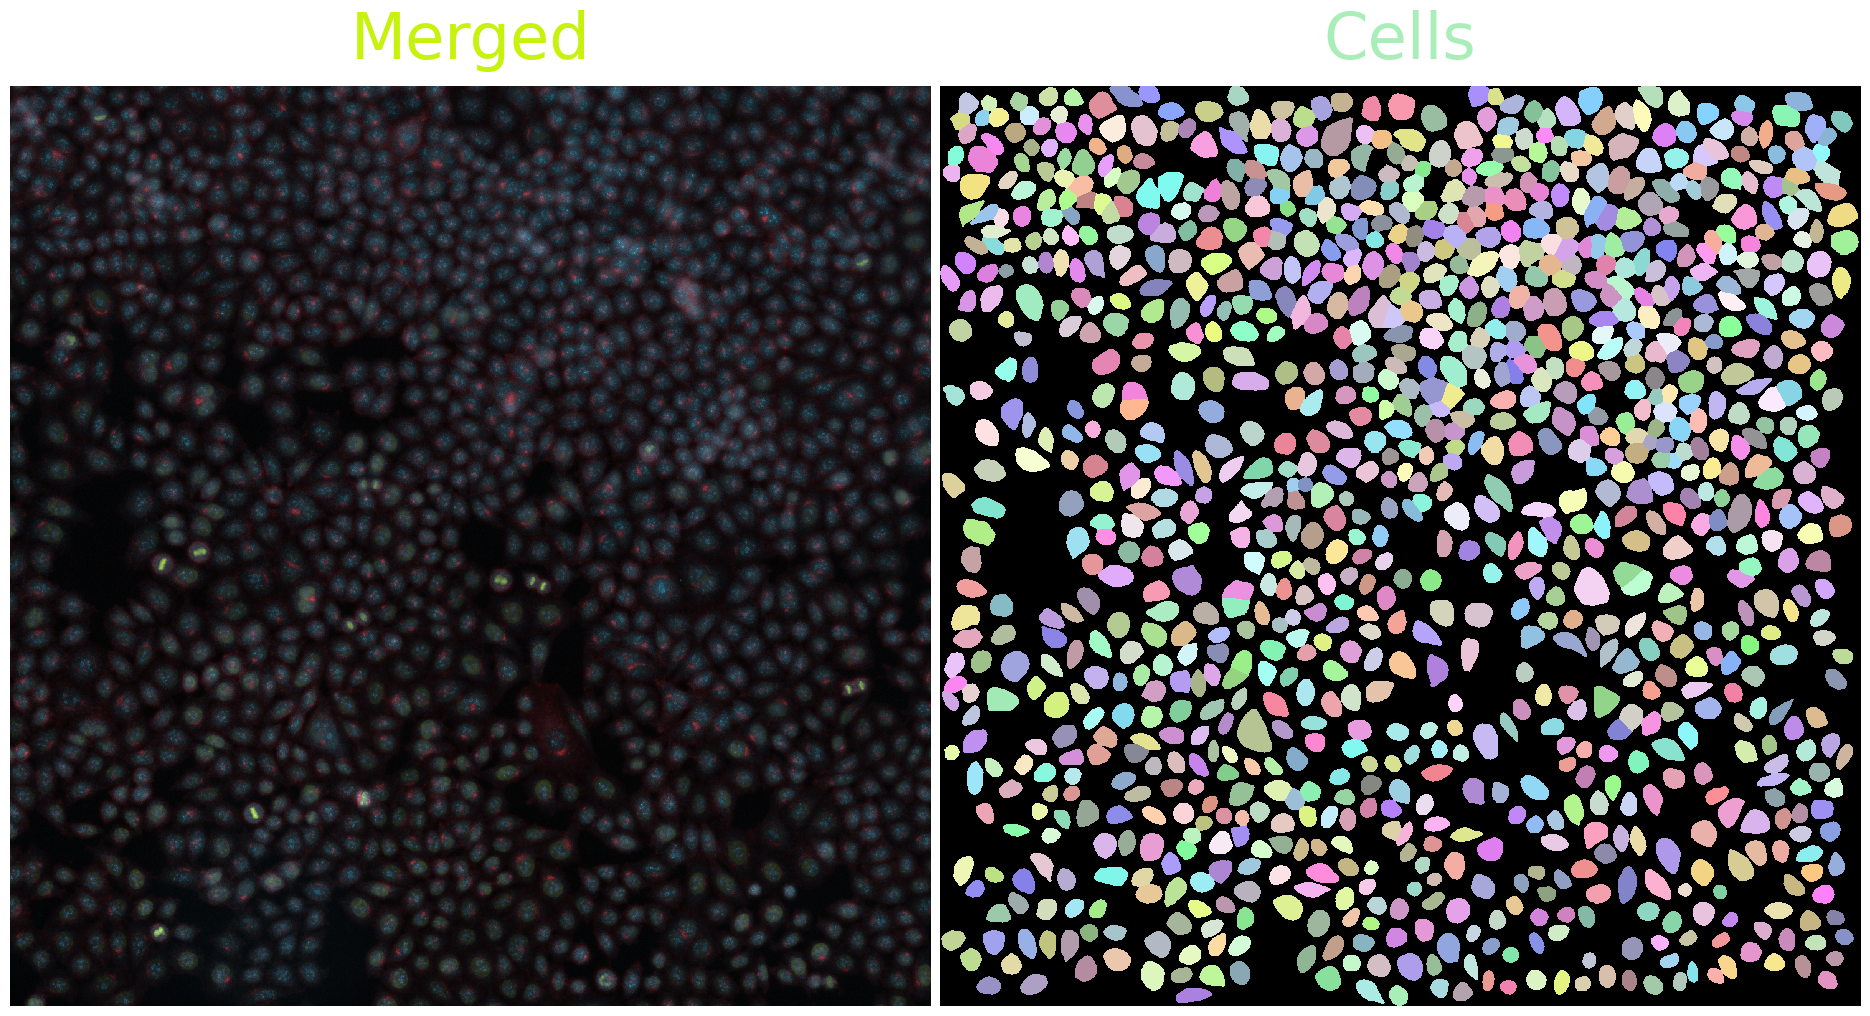

Example microplot for phenotype data annotated with segmenation:


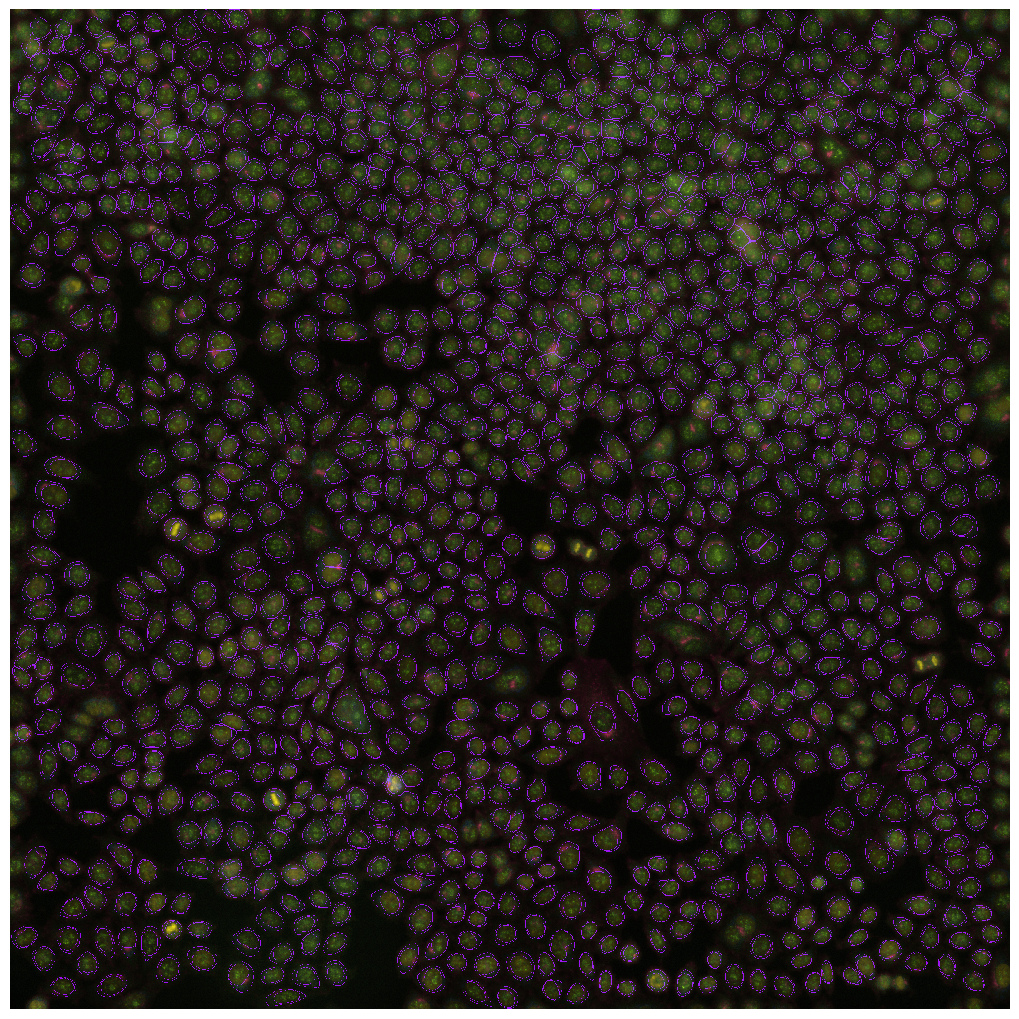

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1108


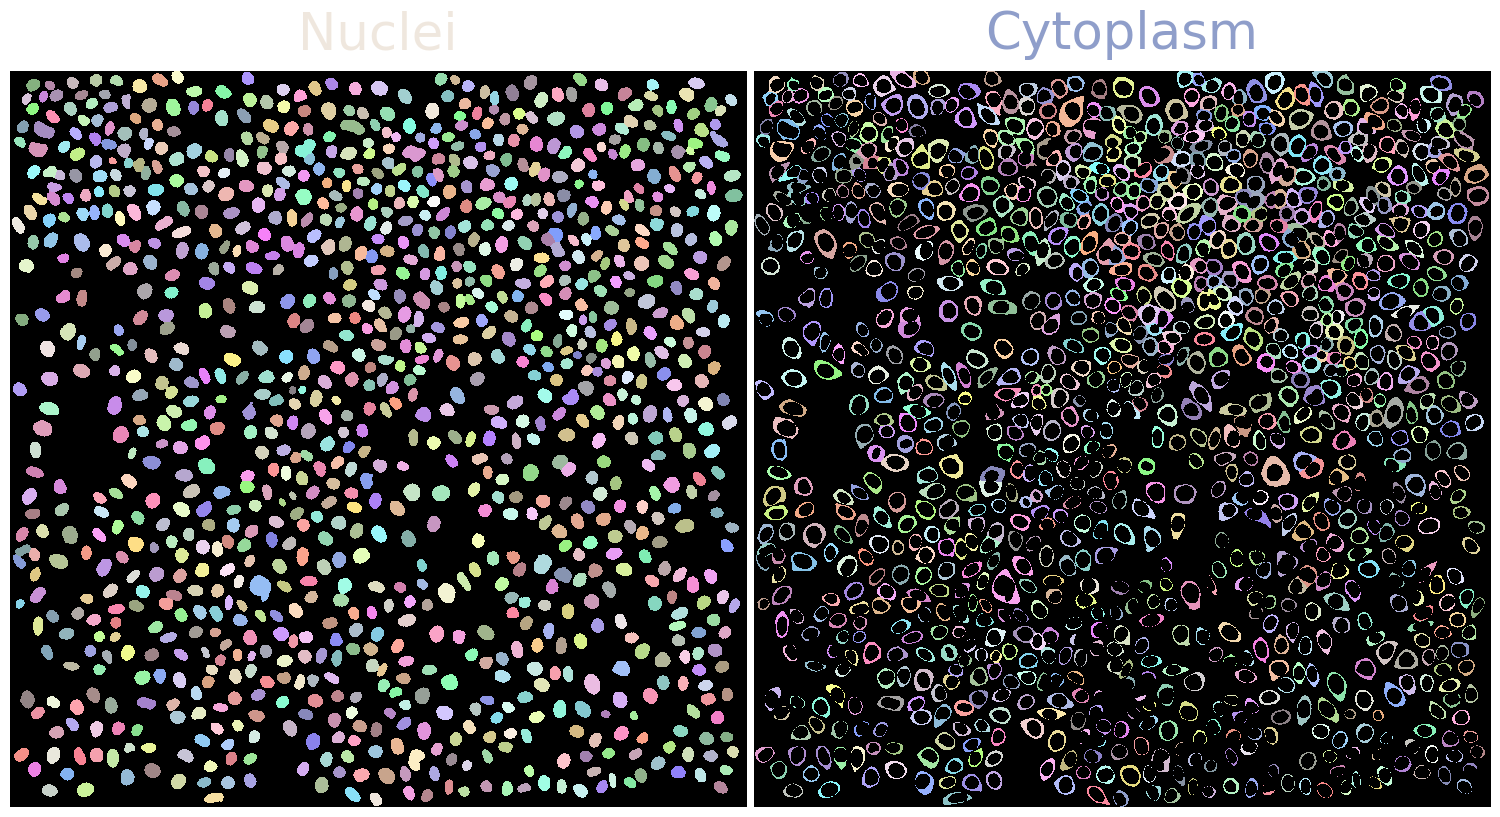

In [6]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL,
)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="DAPI")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

In [7]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(corrected_image, nuclei=nuclei, cells=cells, wildcards=WILDCARDS, cytoplasms=cytoplasms, foci_channel=FOCI_CHANNEL, channel_names=CHANNEL_NAMES)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_COXIV_int  nucleus_CENPA_int  \
0         1           3135293             534038             582923   
1         2           3786318             492744             546597   
2         3           3124775             471900             563913   
3         4           2930437             387101             493311   
4         5           3027936             370987             480642   
...     ...               ...                ...                ...   
1103   1104           3976960             364064             414540   
1104   1105           4168367             382155             455514   
1105   1106           3965498             318117             412327   
1106   1107           4286841             406142             554210   
1107   1108           4026976             341434             422846   

      nucleus_WGA_int  nucleus_DAPI_mean  nucleus_COXIV_mean  \
0             5176469        2393.353435          407.662595   
1             4475841        2708.381974          352.463519   
2             4644550        2344.167292          354.013503   
3             3512215        2075.380312          274.150850   
4             4630854        1881.874456          230.569919   
...               ...                ...                 ...   
1103          3496873        4173.095488          382.018888   
1104          3710826        2392.862801          219.377153   
1105          3403643        3142.232964          252.073693   
1106          3677455        2615.522270          247.798658   
1107          3672125        2954.494497          250.501834   

      nucleus_CENPA_mean  nucleus_WGA_mean  nucleus_DAPI_std  ...  \
0             444.979389       3951.503053        540.402441  ...   
1             390.984979       3201.603004        600.260326  ...   
2             423.040510       3484.283571        412.466545  ...   
3             349.370397       2487.404391        389.473019  ...   
4             298.720945       2878.094469        344.991019  ...   
...                  ...               ...               ...  ...   
1103          434.984260       3669.331584       1159.523359  ...   
1104          261.489093       2130.210103        515.244408  ...   
1105          326.725040       2697.022979        506.782669  ...   
1106          338.139109       2243.718731        505.075680  ...   
1107          310.231842       2694.148936        509.277697  ...   

      cell_number_neighbors_1  cell_percent_touching_1  \
0                           1                 0.122549   
1                           0                 0.000000   
2                           1                 0.163636   
3                           0                 0.000000   
4                           1                 0.091228   
...                       ...                      ...   
1103                        0                 0.000000   
1104                        0                 0.000000   
1105                        0                 0.000000   
1106                        0                 0.000000   
1107                        0                 0.000000   

      cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                        59.673347                      72.186361   
1                        74.871708                      85.773016   
2                        44.936305                      64.859543   
3                        58.625492                      73.788342   
4                        59.673347                      67.770129   
...                            ...                            ...   
1103                     55.057902                      74.873798   
1104                     70.703441                      77.539251   
1105                     59.906395                      71.838771   
1106                     59.378550                      71.692982   
1107                     77.539251                      81.822856   

      cell_angle_between_neig

## Add phenotype process parameters to config file

In [8]:
# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "cyto_model": CYTO_MODEL,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)